<a href="https://colab.research.google.com/github/AadityaSukhoi/CNN-Models/blob/main/BloodCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aadityaranjanmoitra","key":"fc1371992c385c0e35f5e0e48f58da2b"}'}

In [2]:
import os
!mkdir -p ~/.kaggle # Create a hidden kaggle directory
!mv kaggle.json ~/.kaggle/ # Move kaggle.json here
!chmod 600 ~/.kaggle/kaggle.json # Set proper permissions

In [3]:
!kaggle datasets download -d sumithsingh/blood-cell-images-for-cancer-detection

Dataset URL: https://www.kaggle.com/datasets/sumithsingh/blood-cell-images-for-cancer-detection
License(s): Attribution 4.0 International (CC BY 4.0)


In [4]:
!unzip -q blood-cell-images-for-cancer-detection.zip -d blood_cancer_dataset

In [5]:
!ls

blood_cancer_dataset  blood-cell-images-for-cancer-detection.zip  sample_data


In [6]:
import os

image_path = "blood_cancer_dataset"
subfolders = os.listdir(image_path)

print("Subfolders found: ", subfolders)

Subfolders found:  ['monocyte', 'basophil', 'myeloblast', 'seg_neutrophil', 'erythroblast']


In [7]:
sample_folder = os.path.join(image_path, subfolders[0])
image_files = os.listdir(sample_folder)

print(f"Total images in {subfolders[0]}: ",len(image_files))
print("First 5 images: ", image_files[:5])

Total images in monocyte:  1000
First 5 images:  ['MO_256427.jpg', 'MO_37784.jpg', 'MO_225079.jpg', 'MO_102400.jpg', 'MO_146598.jpg']


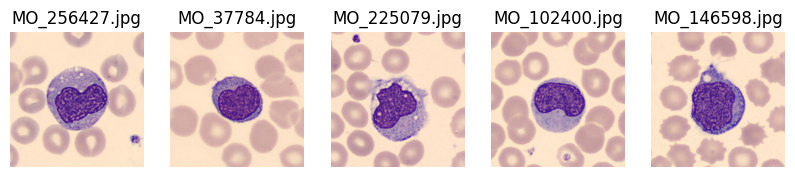

In [8]:
import cv2
import matplotlib.pyplot as plt

# Set all image file path inside subfolders
all_images = []
for subfolder in subfolders:
    folder_path = os.path.join(image_path, subfolder)
    for img_name in os.listdir(folder_path):
      img_path = os.path.join(folder_path, img_name)
      all_images.append(img_path)

# Display first few images
fig, axes = plt.subplots(1, 5, figsize=(10, 20))

for i, img_path in enumerate(all_images[:5]): # Take first 5 images
    img = cv2.imread(img_path)

    if img is None:
      print(f"Skipping {img_path} (not readable)")
      continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(os.path.basename(img_path))

plt.show()

In [9]:
# Import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [10]:
# Set Image Dimensions and Paths
IMAGE_SIZE = (128, 128) # Resize image to 128x128
DATASET_PATH = "blood_cancer_dataset"

In [11]:
# Get subfolders (class names)
class_names = os.listdir(DATASET_PATH)
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")

Number of classes: 5
Classes: ['monocyte', 'basophil', 'myeloblast', 'seg_neutrophil', 'erythroblast']


In [12]:
# Load dataset
def load_dataset(image_size=IMAGE_SIZE):
  images, labels = [], []

  for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(DATASET_PATH, class_name)
    for img_name in os.listdir(class_folder):
      img_path = os.path.join(class_folder, img_name)
      img = cv2.imread(img_path)

      if img is None:
        print(f"Skipping corrupted image: {img_path}")
        continue

      img = cv2.resize(img, image_size) # Resize
      img = img/255.0 # Normalize 0-1 range

      images.append(img)
      labels.append(class_index)

  return np.array(images), np.array(labels)


In [13]:
# Load and split the dataset
X, y = load_dataset()
print("Total Images: ",X.shape[0])

Total Images:  5000


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Training Images: ",X_train.shape[0], "Testing Images: ",X_test.shape[0])

Training Images:  4000 Testing Images:  1000


In [15]:
# # Data Augmentation
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True)
# datagen.fit(X_train)

In [16]:
# Create Custom CNN Model
def create_model():
  model = Sequential([
      Conv2D(32, (3, 3), activation='relu',
             input_shape=(128,128,3)),
      MaxPooling2D(2,2),

      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D(2,2),

      Conv2D(128, (3, 3), activation='relu'),
      MaxPooling2D(2,2),

      Flatten(),
      Dense(128, activation='relu'),
      Dropout(0.5), # Prevent Overfitting
      Dense(len(class_names), activation='softmax') # Output layer (Number of classes)
  ])

  model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [17]:
model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Callbacks (Early Stopping and Checkpoint)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', save_best_only=True)
]

In [19]:
# Train the Model without Data Augmentation
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/20
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3449 - loss: 1.4812

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3466 - loss: 1.4782 - val_accuracy: 0.7860 - val_loss: 0.7609
Epoch 2/20
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6961 - loss: 0.7929

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6969 - loss: 0.7916 - val_accuracy: 0.8970 - val_loss: 0.4027
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8209 - loss: 0.5224

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8210 - loss: 0.5222 - val_accuracy: 0.9340 - val_loss: 0.2954
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8646 - loss: 0.4249

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8648 - loss: 0.4244 - val_accuracy: 0.9450 - val_loss: 0.2105
Epoch 5/20
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9102 - loss: 0.3104

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9103 - loss: 0.3103 - val_accuracy: 0.9490 - val_loss: 0.1688
Epoch 6/20
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9215 - loss: 0.2620

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9215 - loss: 0.2619 - val_accuracy: 0.9530 - val_loss: 0.1444
Epoch 7/20
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9166 - loss: 0.2623

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9167 - loss: 0.2620 - val_accuracy: 0.9590 - val_loss: 0.1382
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9431 - loss: 0.2080

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9430 - loss: 0.2080 - val_accuracy: 0.9580 - val_loss: 0.1262
Epoch 9/20
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9365 - loss: 0.2023

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9365 - loss: 0.2022 - val_accuracy: 0.9620 - val_loss: 0.1148
Epoch 10/20
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9346 - loss: 0.1948

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9348 - loss: 0.1944 - val_accuracy: 0.9640 - val_loss: 0.0992
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9470 - loss: 0.1617 - val_accuracy: 0.9610 - val_loss: 0.1099
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9478 - loss: 0.1526 - val_accuracy: 0.9720 - val_loss: 0.1047
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9452 - loss: 0.1605 - val_accuracy: 0.9660 - val_loss: 0.1243
Epoch 14/20
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9553 - loss: 0.1588

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9553 - loss: 0.1584 - val_accuracy: 0.9700 - val_loss: 0.0923
Epoch 15/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9585 - loss: 0.1371 - val_accuracy: 0.9720 - val_loss: 0.1052
Epoch 16/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9583 - loss: 0.1357

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9582 - loss: 0.1357 - val_accuracy: 0.9740 - val_loss: 0.0804
Epoch 17/20
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9597 - loss: 0.1256

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9596 - loss: 0.1259 - val_accuracy: 0.9780 - val_loss: 0.0785
Epoch 18/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9627 - loss: 0.1194 - val_accuracy: 0.9690 - val_loss: 0.0953
Epoch 19/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9659 - loss: 0.1088 - val_accuracy: 0.9670 - val_loss: 0.0911
Epoch 20/20
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9690 - loss: 0.0995

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9689 - loss: 0.0996 - val_accuracy: 0.9760 - val_loss: 0.0734


In [20]:
# Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test accuracy: {test_acc * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9759 - loss: 0.0848

✅ Test accuracy: 97.60%


In [21]:
# Save the model
model.save("blood_cancer_cnn.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


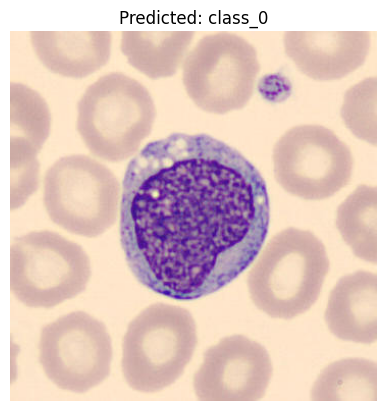

Model Prediction: class_0


In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ensure the model is compiled before making predictions
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Define function to predict image
def predict_image(img_path, model, class_names):
    if not os.path.exists(img_path):
        print(f"Error: Image file not found at {img_path}")
        return

    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Image not loaded! Check file format and path.")
        return

    # Preprocess the image
    img = cv2.resize(img, (128, 128))  # Resize to match model input size
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Expand dimensions for model input

    # Make prediction
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    class_label = class_names[predicted_class]

    # Display image with prediction
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Predicted: {class_label}")
    plt.show()

    return class_label

# Define class names (Update this list as per your dataset)
class_names = ["class_0", "class_1", "class_2", "class_3"]  # Replace with actual class labels

# Path to the test image
test_image_path = os.path.join("blood_cancer_dataset", "monocyte", "MO_134722.jpg")

# Run prediction
prediction = predict_image(test_image_path, model, class_names)
print("Model Prediction:", prediction)